In [1]:
%matplotlib inline
import ROOT
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.patches import Rectangle, Circle
import os # Import the os library

# --- Initial Setup ---
ROOT.gROOT.LoadMacro("../atlasstyle/AtlasStyle.C")
ROOT.gROOT.LoadMacro("../atlasstyle/AtlasUtils.C")
ROOT.gROOT.LoadMacro("../atlasstyle/AtlasLabels.C")
ROOT.SetAtlasStyle()
ROOT.EnableImplicitMT()

# --- Load Delphes Library ---
# Define the path with the tilde
delphes_dir_tilde = "~/research/Delphes-3.5.0/"
# Use os.path.expanduser to get the full, absolute path
delphes_dir = os.path.expanduser(delphes_dir_tilde)

# Load the library using the full path
status = ROOT.gSystem.Load(delphes_dir + "libDelphes.so")

# Declare the header using the full path and quotes ""
ROOT.gInterpreter.Declare(f'#include "{delphes_dir}classes/DelphesClasses.h"')

if status == 0:
    print("libDelphes.so loaded successfully!")
else:
    print(f"Error: Could not load {delphes_dir}libDelphes.so")
    # exit() # Use exit() in a script, not a notebook

fdir = delphes_dir + "displacedPhoton/dark_events.root"

# Now this will work
print("Successfully included Delphes header.")


Applying ATLAS style settings...

libDelphes.so loaded successfully!
Successfully included Delphes header.


In [2]:
# Create the RDataFrame
df_init = ROOT.RDataFrame("Delphes", fdir)

# The Photon.T branch is in seconds, so this is a 12 ns cut.
TIME_CUT_NS = 12.*10**-9

# Filter for events with at least one photon
df_photons = df_init.Filter("Photon_size > 0", "Events with at least one photon")

# Filter for events containing at least one late-arriving photon
df_late = df_photons.Filter(f"ROOT::VecOps::Max(Photon.T) > {TIME_CUT_NS}", f"Select events with photons T > {TIME_CUT_NS*10**9} ns")

# In these events, find the index of the LATEST arriving photon
df_with_idx = df_late.Define("idx_late_photon", "ROOT::VecOps::ArgMax(Photon.T)")

# Add a filter to ensure the late photon has a matched GenParticle to prevent errors
df_matched = df_with_idx.Filter("Photon.Particles[idx_late_photon].GetEntries() > 0", "Late photon has a matched GenParticle")

# --- CORRECTED LINE ---
# Use reinterpret_cast to directly treat the object as a GenParticle, bypassing runtime type checks.
df_safer = df_matched.Define("matched_gen_particle", "reinterpret_cast<GenParticle*>(Photon.Particles[idx_late_photon].At(0))")

# Use the C++ ternary operator to check if the pointer is valid before accessing its members.
# This is still good practice, just in case the pointer is genuinely null.
df_final = df_safer.Define("v_x", "(matched_gen_particle != nullptr) ? matched_gen_particle->X : -999.0") \
                   .Define("v_y", "(matched_gen_particle != nullptr) ? matched_gen_particle->Y : -999.0") \
                   .Define("v_z", "(matched_gen_particle != nullptr) ? matched_gen_particle->Z : -999.0") \
                   .Define("pt_late_photon", "Photon.PT[idx_late_photon]") \
                   .Define("eta_late_photon", "Photon.Eta[idx_late_photon]") \
                   .Define("phi_late_photon", "Photon.Phi[idx_late_photon]") \
                   .Define("t_late_photon", "Photon.T[idx_late_photon]")

# --- Data Conversion ---
data = df_final.AsNumpy(["v_x", "v_y", "v_z", "pt_late_photon", "eta_late_photon", "phi_late_photon", "t_late_photon", "Event.Number"])
df = pd.DataFrame(data)

if not df.empty:
    df["event_number"] = df["Event.Number"].apply(lambda x: x[0])
    df.sort_values(by="event_number", inplace=True)
    df.drop(columns=["Event.Number"], inplace=True)
df

,v_x,v_y,v_z,pt_late_photon,eta_late_photon,phi_late_photon,t_late_photon,event_number
1263,-999.0,-999.0,-999.0,31.139708,-1.970839,-1.247212,1.234454e-08,8
1264,-999.0,-999.0,-999.0,55.487484,-2.077537,1.321660,1.223461e-08,10
1265,-999.0,-999.0,-999.0,14.325616,2.140976,-2.461170,1.631220e-08,64
1266,-999.0,-999.0,-999.0,17.031054,1.575877,-1.441995,1.667283e-08,68
1267,-999.0,-999.0,-999.0,68.516098,2.163268,-0.983888,1.206545e-08,71
...,...,...,...,...,...,...,...,...
2465,-999.0,-999.0,-999.0,14.672729,-1.298992,-2.365386,1.324786e-08,39969
2466,-999.0,-999.0,-999.0,34.515305,1.798520,2.601394,1.283249e-08,39974
2467,-999.0,-999.0,-999.0,102.763039,-2.176073,2.977256,1.227877e-08,39978
2468,-999.0,-999.0,-999.0,35.582005,-2.032096,2.384253,1.253397e-08,39989


In [7]:
def plot_event(event, save: bool = False):
    assert event in df['event_number'].values, f"Event {event} not found in the data."
    event_data = df[df['event_number'] == event].iloc[0]

    # Extract properties for the chosen event
    phi = event_data['phi_late_photon']
    eta = event_data['eta_late_photon']
    pt = event_data['pt_late_photon']
    time = event_data['t_late_photon']

    v_x = event_data['v_x']
    v_y = event_data['v_y']
    v_z = event_data['v_z']
    v_r = np.sqrt(v_x**2 + v_y**2)

    # Get Particle End Coordinates
    end_x = v_x + 2500 * np.cos(phi) * 2 # so line reaches end of frame
    end_y = v_y + 2500 * np.sin(phi) * 2

    theta = 2 * np.arctan(np.exp(-eta))
    end_z = v_z + 5000 * np.cos(theta)
    end_r = v_r + 5000 * np.sin(theta)

    # --- Create the Plots ---
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))
    fig.suptitle(f'Path of Latest Photon for Event #{int(event)} (T = {time*(10**9):.2f} ns) ($p_{{T}}$={pt:.2f} GeV)', fontsize=16)

    # 1. Transverse View (x-y plane)
    ax1.set_title("Transverse View (x-y plane)", fontsize=14)
    ax1.set_xlabel("x [mm]"); ax1.set_ylabel("y [mm]")
    ax1.set_xlim(-2500, 2500); ax1.set_ylim(-2500, 2500)
    ax1.set_aspect('equal', adjustable='box')
    em_calorimeter = plt.Circle((0, 0), 2077, color='lightblue', alpha=0.3, label='Calorimeter')
    ax1.add_patch(em_calorimeter)
    ax1.plot(0, 0, 'ro', markersize=5, label='Beam Line (x=0,y=0)')
    ax1.plot(v_x, v_y, 'r+', markersize=15, label='Primary Vertex')
    ax1.plot([v_x, end_x], [v_y, end_y], 'g-', lw=2, label='Photon Path')
    ax1.legend(loc='upper right') 
    ax1.grid(True, linestyle='--')

    # 2. Longitudinal View (r-z plane)
    ax2.set_title("Longitudinal View (r-z plane)", fontsize=14)
    ax2.set_xlabel("z [mm]")
    ax2.set_ylabel(r"r = $\sqrt{x^2+y^2}$ [mm]")
    ax2.set_xlim(-3000, 3000); ax2.set_ylim(0, 4000)
    em_barrel = plt.Rectangle((-2077, 0), 4154, 3200, color='lightblue', alpha=0.3, label='Calorimeter')
    ax2.add_patch(em_barrel)
    ax2.axhline(0, color='r', linestyle='--', lw=2, label='Beam Line (r=0)')
    ax2.plot(v_z, v_r, 'r+', markersize=15, label='Primary Vertex')
    ax2.plot([v_z, end_z], [v_r, end_r], 'g-', lw=2, label='Photon Path')
    ax2.legend(loc='upper right')
    ax2.grid(True, linestyle='--')

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()
    if save:
        fig.savefig(f'dark_plots/event_{int(event)}.png')


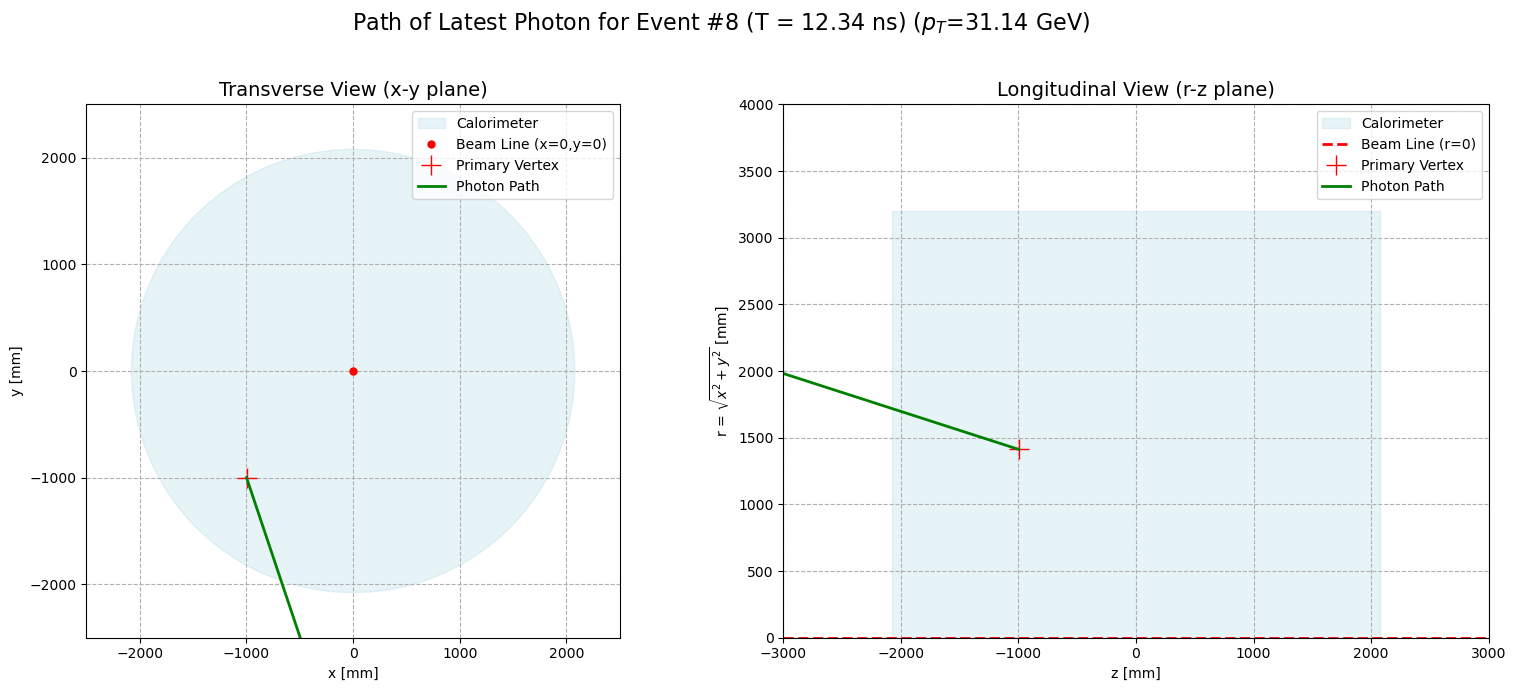

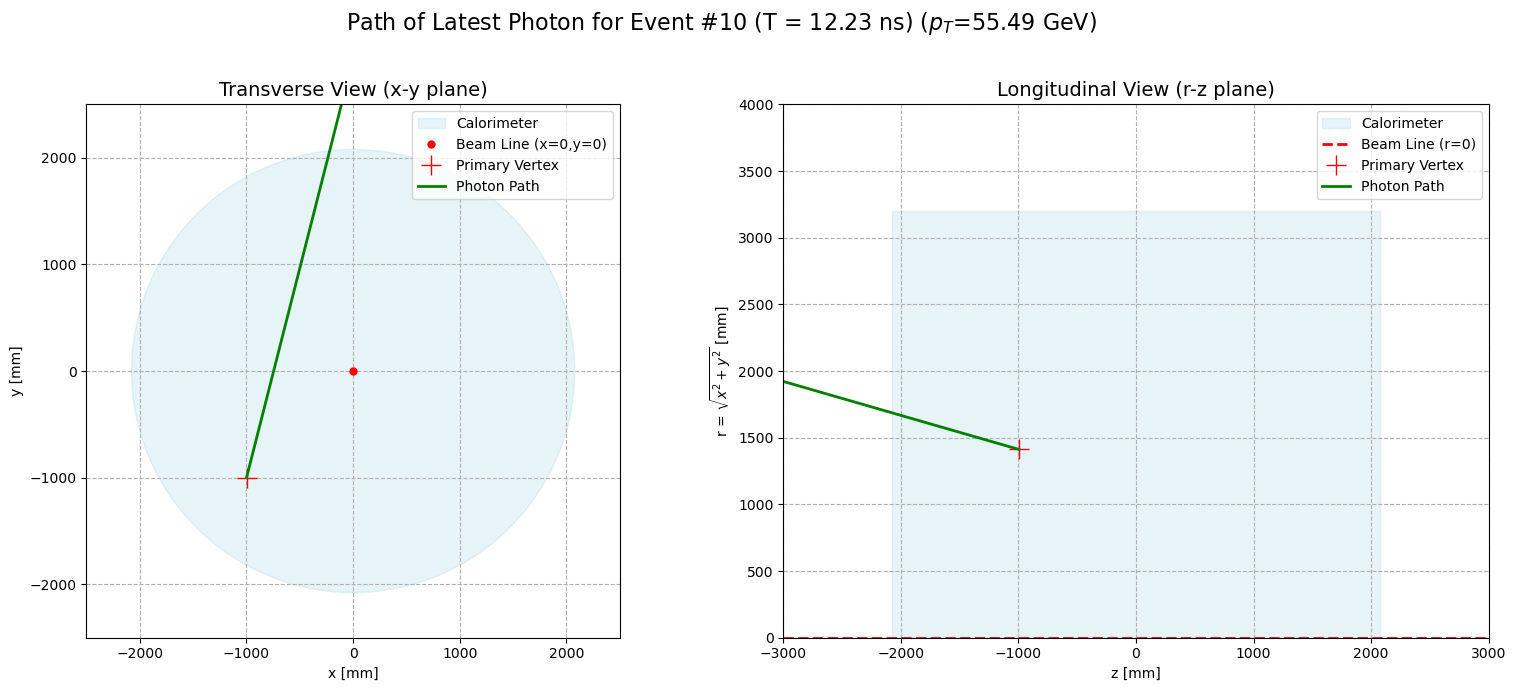

In [8]:
for event in df['event_number'][:2].values:
    fig = plot_event(event)